In [5]:
import os
import sys
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Check versions of libraries
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"tensorflow: {tf.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Python: 3.8.5 (default, May 27 2021, 13:30:53) 
[GCC 9.3.0]
numpy: 1.18.5
tensorflow: 2.3.0


In [6]:
CURRENT_DIR = os.getcwd()
TRAINING_SET_DIR = os.path.join(CURRENT_DIR, "images", "training_set")
VALIDATION_SET_DIR = os.path.join(CURRENT_DIR, "images", "validation_set")

EPOCHS = 1
BATCH_SIZE = 16
NUMBER_OF_TRAINING_IMAGES = 0
NUMBER_OF_VALIDATION_IMAGES = 0

# Must be the same input size as the base model
# Currently using: InceptionV3 - (299, 299)
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299

In [7]:
image_generator_train = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.4, 1],
    channel_shift_range=30,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True
)

data_generator_train = image_generator_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=TRAINING_SET_DIR,
    shuffle=True,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="categorical"
)

image_generator_validation = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

data_generator_validation = image_generator_validation.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=VALIDATION_SET_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="categorical"
)

NUMBER_OF_TRAINING_IMAGES = data_generator_train.samples
NUMBER_OF_VALIDATION_IMAGES = data_generator_validation.samples

sample_images_train, _ = next(data_generator_train)

Found 65228 images belonging to 130 classes.
Found 5200 images belonging to 130 classes.


In [8]:
def image_view(images, rows, columns):
    """Displays the first NxM images in a NxM subplot"""

    fig, ax = plt.subplots(rows, columns, figsize=(8, 8))
    image_index = 0

    for i in range(rows):
        for j in range(columns):
            ax[i, j].imshow(images[image_index])
            ax[i, j].axis("off")
            image_index += 1

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.show()

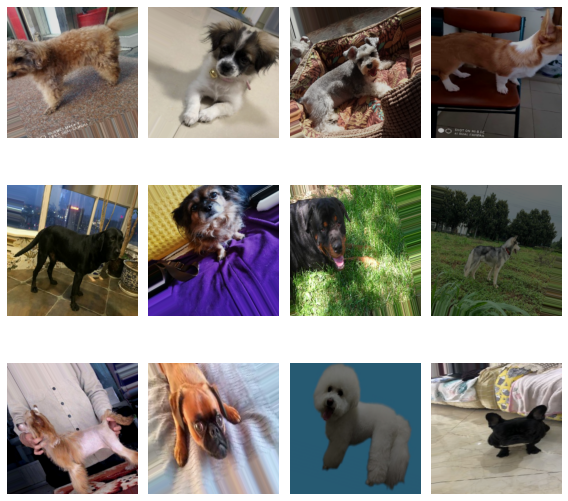

In [9]:
image_view(sample_images_train, 3, 4)

In [10]:
"""Model"""
base_model = keras.applications.inception_v3.InceptionV3(
    weights="imagenet", include_top=False, input_shape=(299, 299, 3)
)

model = base_model.output
model = keras.layers.GlobalAveragePooling2D()(model)
model = keras.layers.Dense(512, activation="relu")(model)
model = keras.layers.Dense(512, activation="relu")(model)

# 130 breeds (classes)
model_outputs = keras.layers.Dense(130, activation="softmax")(model)
model = keras.models.Model(inputs=base_model.input, outputs=model_outputs)

for layer in base_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 12s 0us/step


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
history = model.fit(
    data_generator_train,
    epochs=EPOCHS,
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // BATCH_SIZE,
    validation_data=data_generator_validation,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // BATCH_SIZE
)

 846/4076 [=====>........................] - ETA: 26:10 - loss: 1.3049 - accuracy: 0.6703

KeyboardInterrupt: 

In [ ]:
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
validation_loss = history.history["val_loss"]

In [ ]:
"""Plot accuracy of model by epochs"""
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label="Training Accuracy")
plt.plot(range(EPOCHS), validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

"""Plot loss of model by epochs"""
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [143]:
# model.summary()
# model.save("model")

loaded_model = keras.models.load_model(os.path.join(CURRENT_DIR, "model"))
# loaded_model.summary()

In [164]:
"""Testing the model with an image"""
class_names = np.array([
    name[0] for name in sorted(data_generator_train.class_indices.items())
])

image_dir = os.path.join("/home/kenroku/Downloads/udacity/train/057.Dalmatian", "Dalmatian_04004.jpg")

image = keras.preprocessing.image.load_img(image_dir, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
image_tensor = keras.preprocessing.image.img_to_array(image)
image_tensor = np.expand_dims(image_tensor, axis=0)
image_tensor = image_tensor / 255

predictions = loaded_model.predict(image_tensor)

# Get top 1 prediction
predicted_classes = class_names[np.argmax(predictions, axis=-1)]
print("Top prediction:", predicted_classes)

# Get top 5 predictions
print("Top 5 choices:")
prediction_probabilities = np.argsort(predictions, axis=-1)[0][::-1][:5]
for choice, names in enumerate(prediction_probabilities):
    print(str(choice + 1) + ") " + class_names[names])

Top prediction: ['miniature_schnauzer-n000102']
Top 5 choices:
1) miniature_schnauzer-n000102
2) teddy-n000128
3) Bichon_Frise-n000117
4) Chinese_Crested_Dog-n000093
5) toy_poodle-n000114
